# HW 7 Maslakov
Anaysis of Drosophila dataset 
<br>
Drosophila neuroblast tumors, https://elifesciences.org/articles/50375. Link to the dataset: https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSM3161971

In [96]:
import os
import scanpy as sc
import gzip
import os
import numpy as np 
import pandas as pd

In [10]:
# download all files form GEO

!wget https://ftp.ncbi.nlm.nih.gov/geo/samples/GSM3161nnn/GSM3161971/suppl/GSM3161971%5Fbarcodes%2Etsv%2Egz -P /home/george/scanpy
!wget https://ftp.ncbi.nlm.nih.gov/geo/samples/GSM3161nnn/GSM3161971/suppl/GSM3161971%5Fgenes%2Etsv%2Egz -P /home/george/scanpy
!wget https://ftp.ncbi.nlm.nih.gov/geo/samples/GSM3161nnn/GSM3161971/suppl/GSM3161971%5Fmatrix%2Emtx%2Egz -P /home/george/scanpy

folder_path = '/home/george/scanpy'
file_list = os.listdir(folder_path)

### Gunzip all files in folder 
for file_name in file_list:
    if file_name.endswith('.gz'):
        input_file = os.path.join(folder_path, file_name)
        output_file = os.path.join(folder_path, os.path.splitext(file_name)[0])
        
        with gzip.open(input_file, 'rb') as f_in:
            with open(output_file, 'wb') as f_out:
                f_out.write(f_in.read())
                
### Remove all .gz files in folder
!rm /home/george/scanpy/*gz*

--2023-05-25 21:12:27--  https://ftp.ncbi.nlm.nih.gov/geo/samples/GSM3161nnn/GSM3161971/suppl/GSM3161971%5Fbarcodes%2Etsv%2Egz
Resolving ftp.ncbi.nlm.nih.gov (ftp.ncbi.nlm.nih.gov)... 165.112.9.228, 130.14.250.12, 2607:f220:41e:250::11, ...
Connecting to ftp.ncbi.nlm.nih.gov (ftp.ncbi.nlm.nih.gov)|165.112.9.228|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 23775 (23K) [application/x-gzip]
Saving to: ‘/home/george/scanpy/GSM3161971_barcodes.tsv.gz.2’

GSM3161971_barcodes 100%[===================>]  23.22K  --.-KB/s    in 0.1s    

2023-05-25 21:12:28 (167 KB/s) - ‘/home/george/scanpy/GSM3161971_barcodes.tsv.gz.2’ saved [23775/23775]

--2023-05-25 21:12:28--  https://ftp.ncbi.nlm.nih.gov/geo/samples/GSM3161nnn/GSM3161971/suppl/GSM3161971%5Fgenes%2Etsv%2Egz
Resolving ftp.ncbi.nlm.nih.gov (ftp.ncbi.nlm.nih.gov)... 165.112.9.228, 130.14.250.12, 2607:f220:41f:250::229, ...
Connecting to ftp.ncbi.nlm.nih.gov (ftp.ncbi.nlm.nih.gov)|165.112.9.228|:443... connected.
H

In [169]:
# Load UMI raw matrices to anndata objects
adata = sc.read_10x_mtx(path=folder_path, prefix= 'GSM3161971_')
adata

AnnData object with n_obs × n_vars = 5789 × 17753
    var: 'gene_ids'

In [170]:
adata.var['mt'] = adata.var_names.str.startswith(r'mt:')  # annotate the group of mitochondrial genes as 'mt'
adata.var = adata.var.fillna(0.001) # Here were some problems with Nans so i've decided to replace it with small value(cuz deleting of a row didnt help)
adata

AnnData object with n_obs × n_vars = 5789 × 17753
    var: 'gene_ids', 'mt'

In [171]:
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

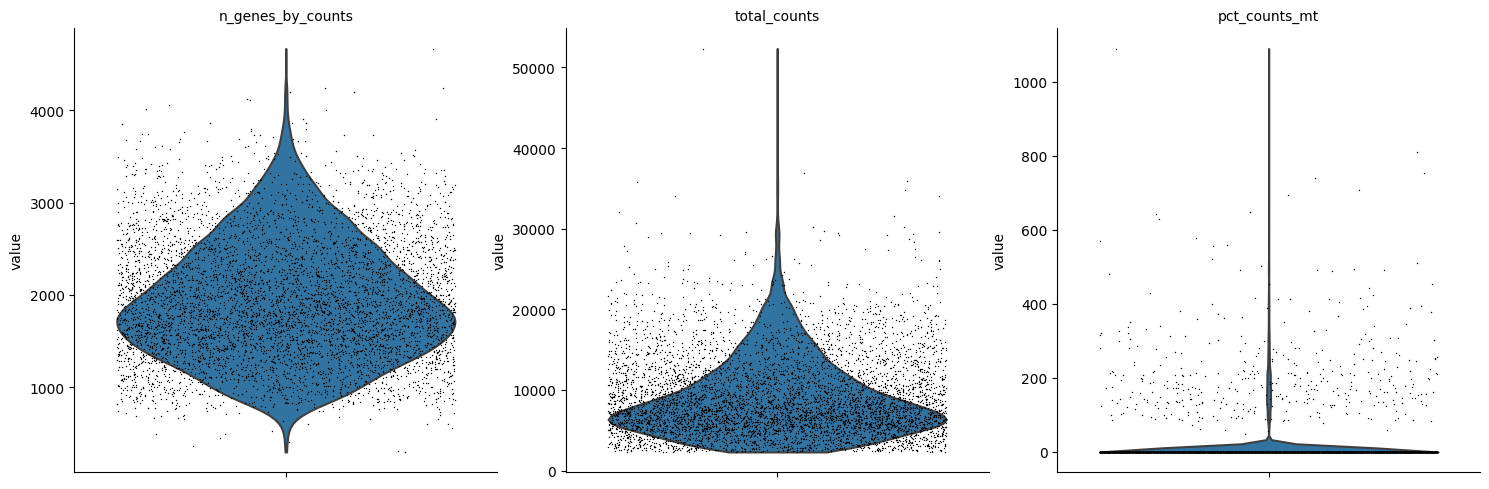

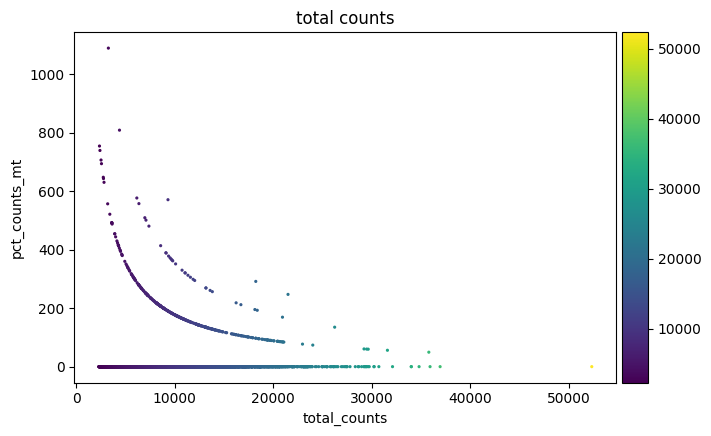

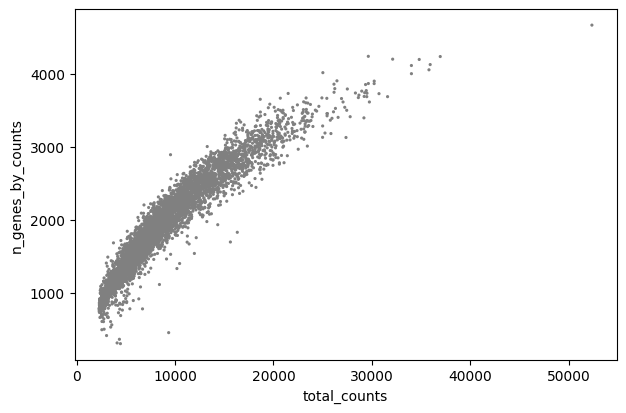

In [172]:
# Lets consctruct some plots
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'], jitter=0.4, multi_panel=True)
sc.pl.scatter(adata, x='total_counts', y='pct_counts_mt', color='total_counts')
sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts')

Filtering data as in article

In [174]:
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_cells(adata, max_genes=4000)
sc.pp.filter_cells(adata, max_counts=10000)

adata = adata[adata.obs.pct_counts_mt < 5, :]

/home/george/micromamba/lib/python3.11/site-packages/anndata/_core/anndata.py:117: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


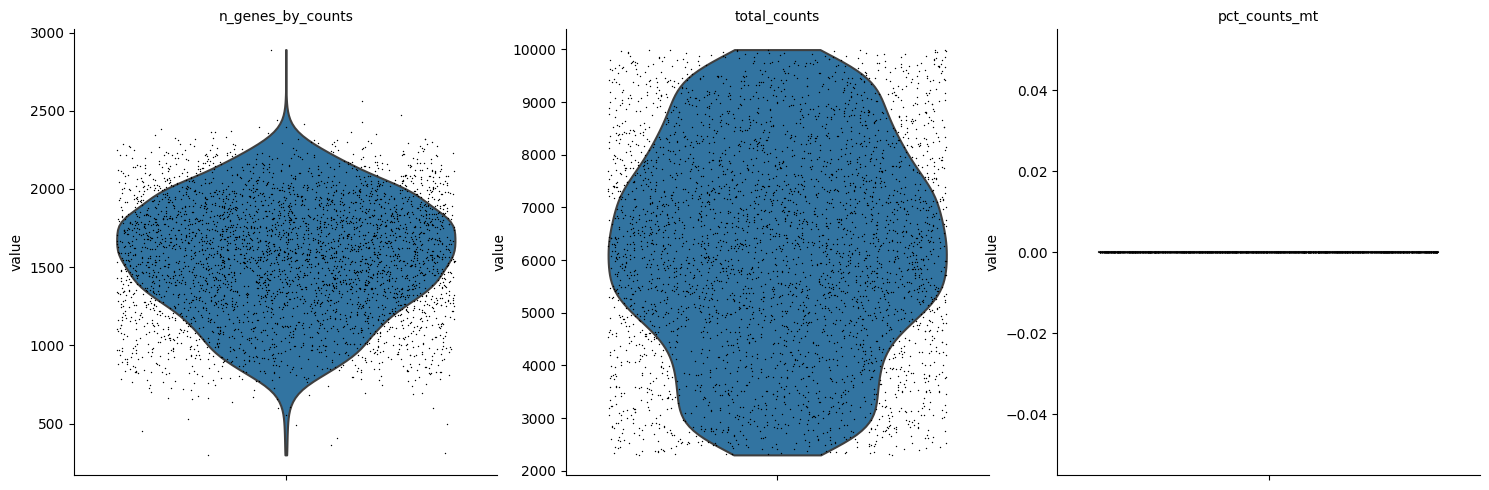

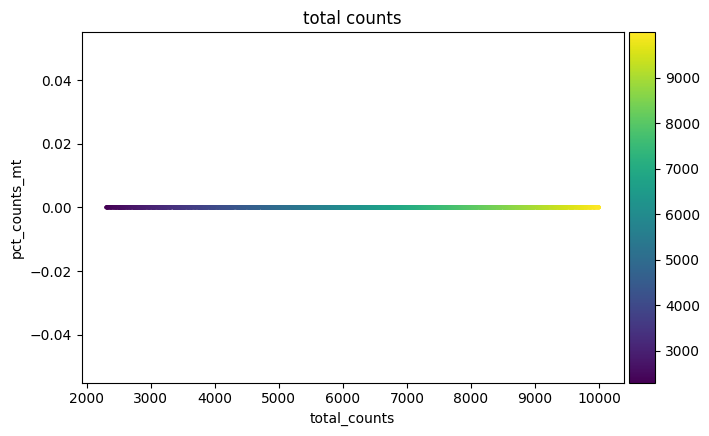

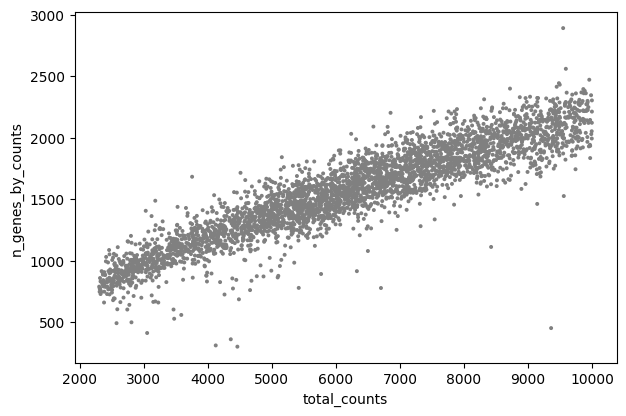

In [175]:
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'], jitter=0.4, multi_panel=True)

sc.pl.scatter(adata, x='total_counts', y='pct_counts_mt', color='total_counts')
sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts')

Now its much better

In [176]:
sc.pp.normalize_total(adata, target_sum=1e4)

/home/george/micromamba/lib/python3.11/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [177]:
sc.pp.log1p(adata)

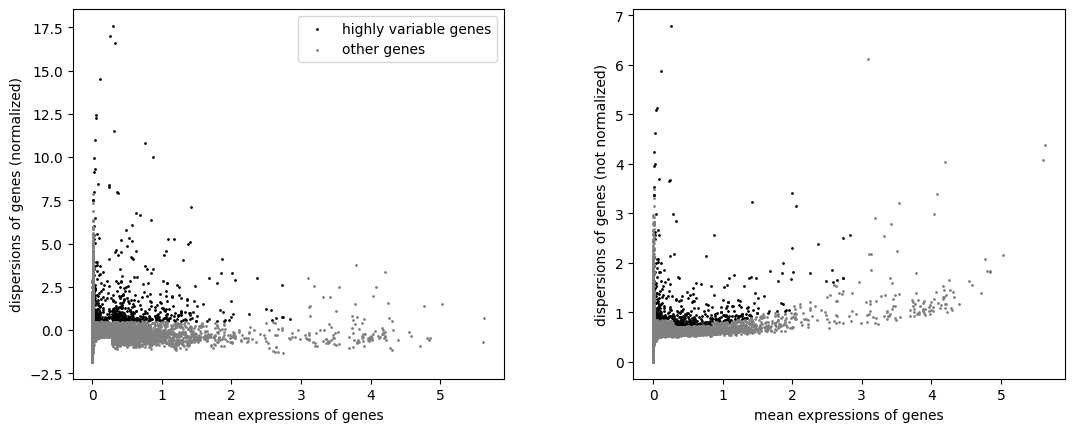

highly_variable
False    17178
True       575
Name: count, dtype: int64

In [178]:
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
sc.pl.highly_variable_genes(adata)
adata.var.highly_variable.value_counts()

In [179]:
adata.raw = adata
adata = adata[:, adata.var.highly_variable]
sc.pp.scale(adata, max_value=10)
sc.tl.pca(adata)

/home/george/micromamba/lib/python3.11/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


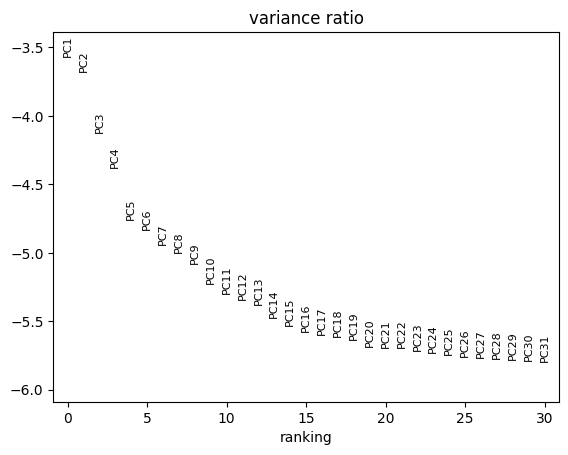

In [180]:
sc.pl.pca_variance_ratio(adata, log=True)
#graphycally represent variance ratio of different principe components

In [181]:
sc.pp.neighbors(adata, n_pcs=15, metric='cosine')

Now we will visualize results with umap and t-sne plots

In [182]:
sc.tl.tsne(adata)

/home/george/micromamba/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  cax = scatter(


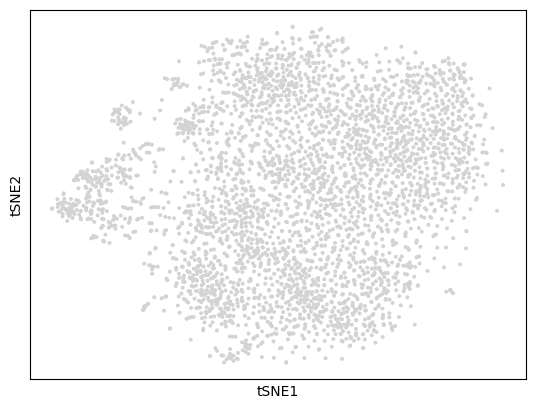

In [183]:
sc.pl.tsne(adata)

In [184]:
sc.tl.umap(adata)

/home/george/micromamba/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  cax = scatter(


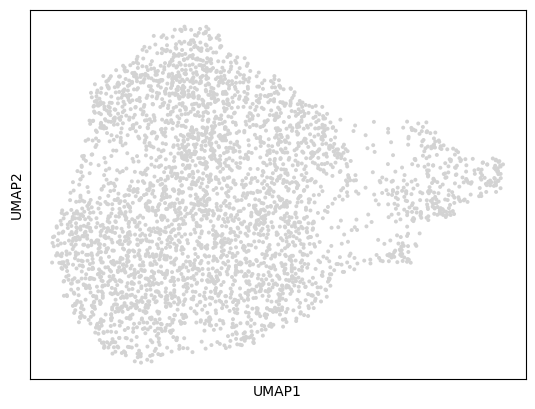

In [196]:
sc.pl.umap(adata)

Lets do some clusterisation 

In [230]:
#!micromamba install -y -c conda-forge leidenalg
sc.tl.leiden(adata,  resolution=0.7)

/home/george/micromamba/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


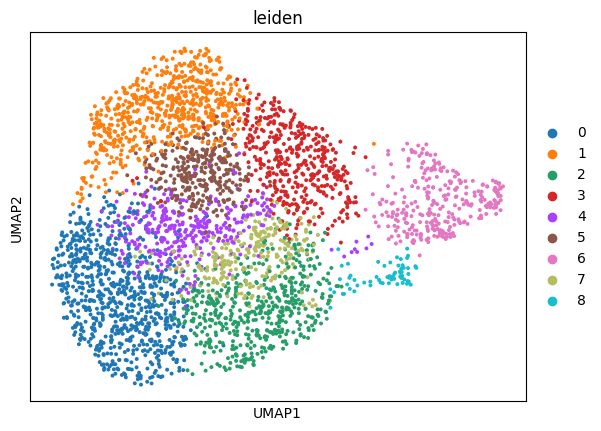

In [231]:
sc.pl.umap(adata, color=['leiden'])

/home/george/micromamba/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


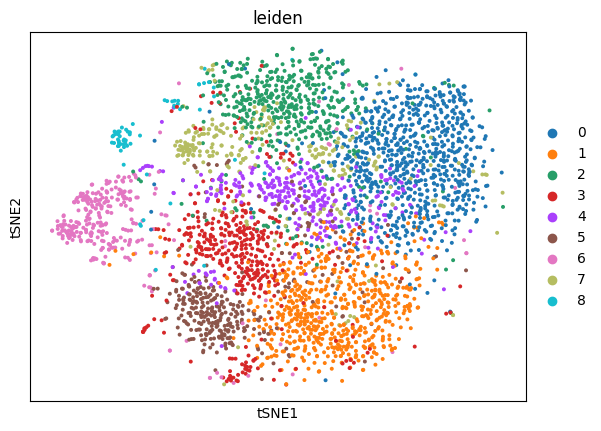

In [232]:
sc.pl.tsne(adata, color=['leiden'])

UMAP looks more concise so lets use it instead of tSNE

/home/george/micromamba/lib/python3.11/site-packages/scanpy/plotting/_dotplot.py:749: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


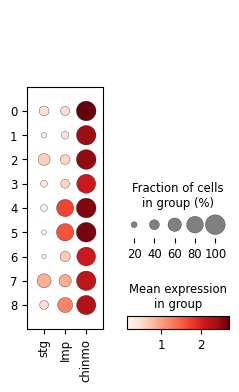

In [233]:
marker_genes = ['stg', 'Imp', 'chinmo']
sc.pl.dotplot(adata, marker_genes, groupby='leiden')

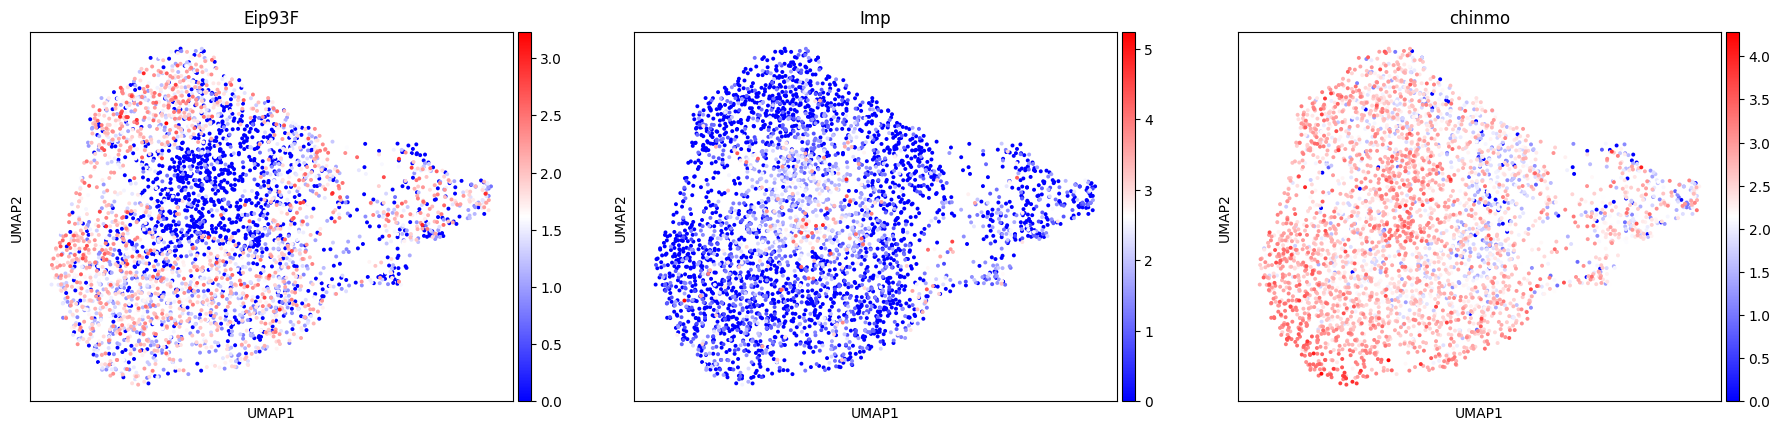

In [234]:
sc.pl.umap(adata, color=['Eip93F', 'Imp', 'chinmo'], color_map='bwr')

We can see the distribution of markers which somehow similar to the article. Eip93F is the marker of late Neuroblasts, and chinmo and Inmp are the markers of early neuroblasts. Imp also is a marker for self-renewal neuroblasts and its expression area is limited to the small island 

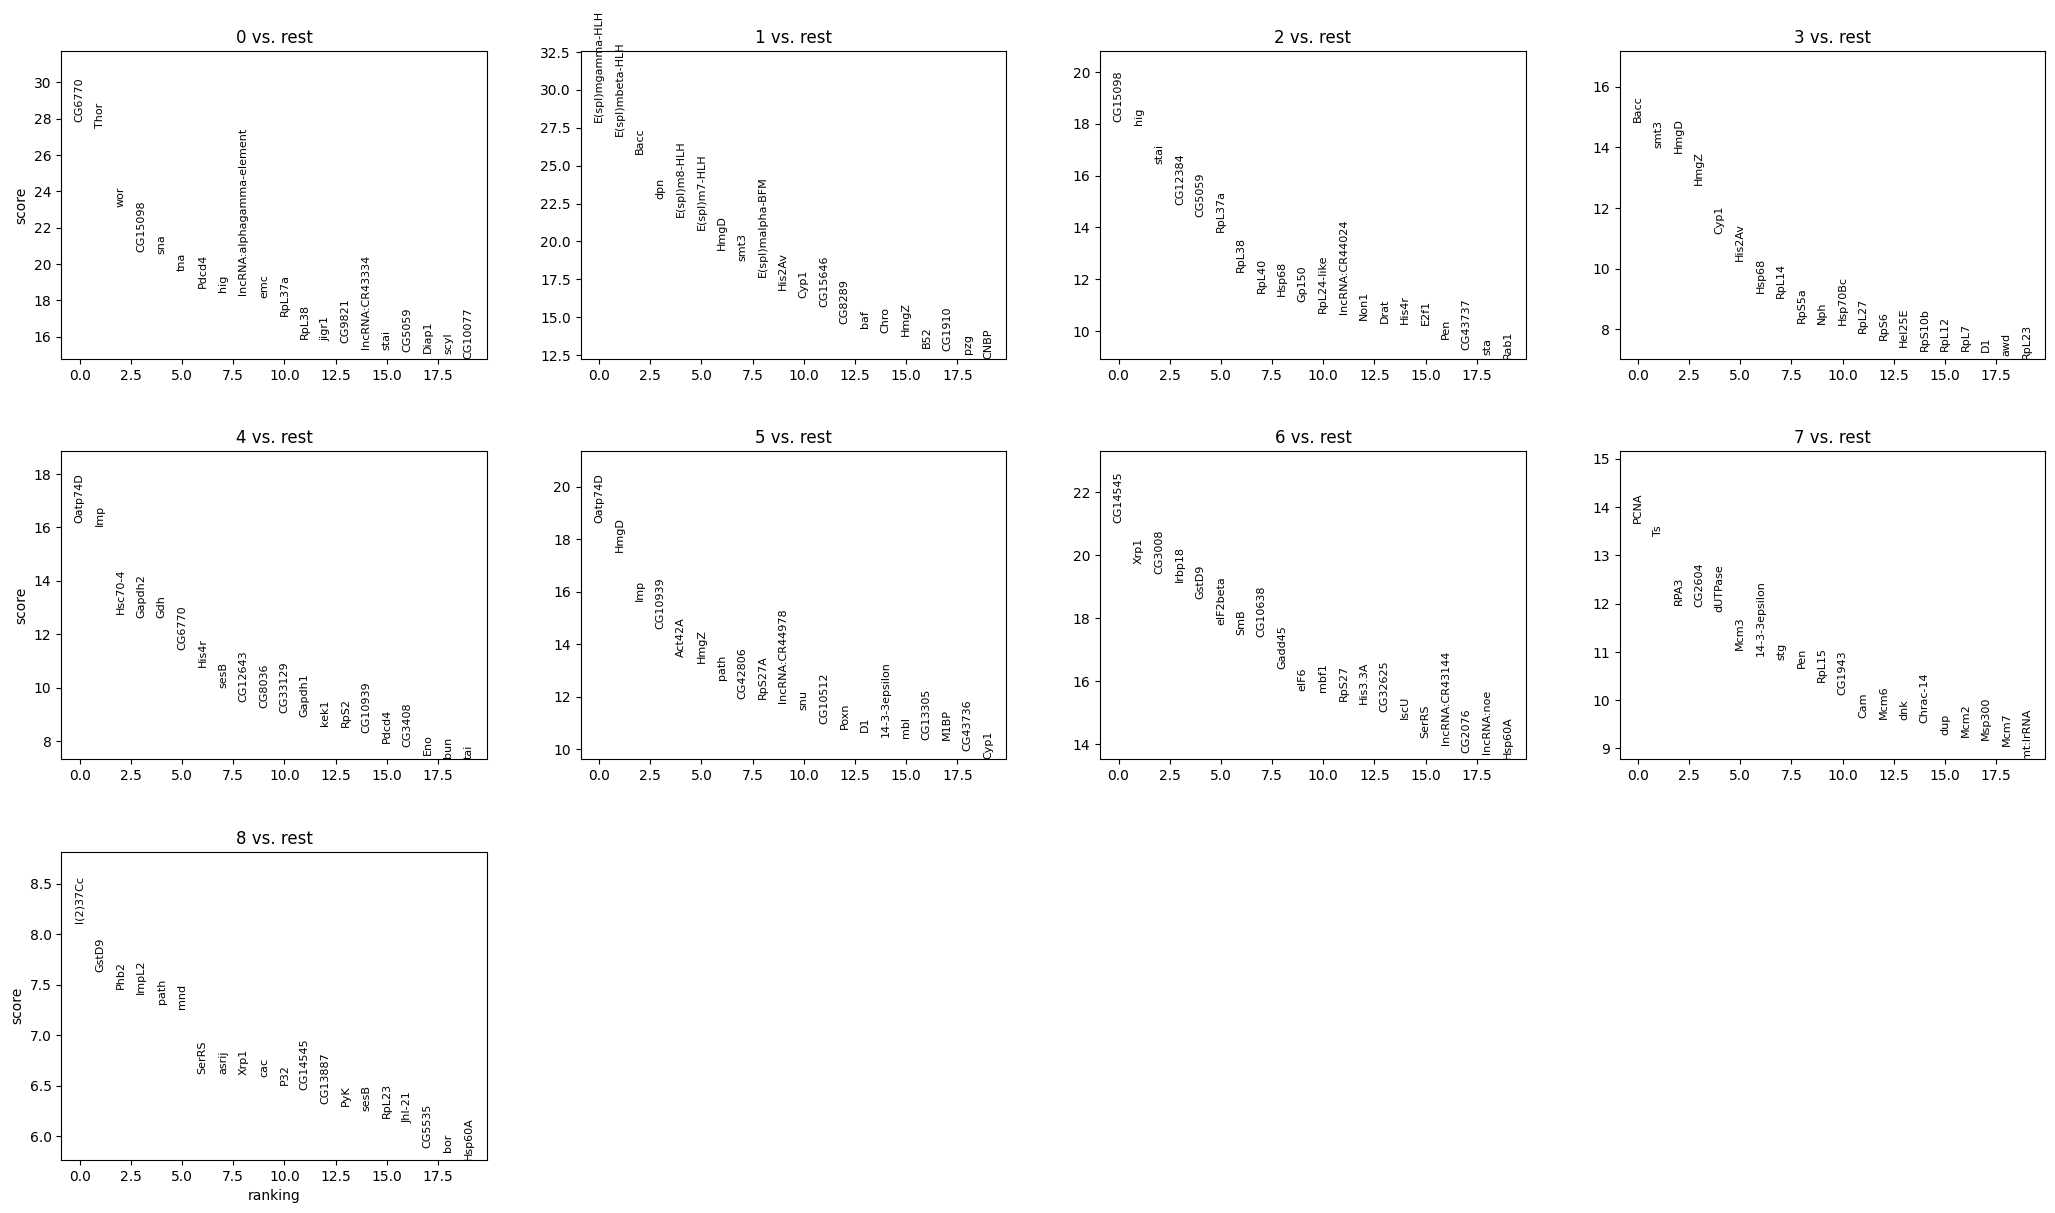

In [259]:
# Differential expression between the clusters

sc.tl.rank_genes_groups(adata, 'leiden', method='wilcoxon')
sc.pl.rank_genes_groups(adata, n_genes=20, sharey=False)

Some extra differential markers